In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
import scipy
import nibabel as nib
import matplotlib as mpl
%matplotlib inline
import brainsss
import h5py
import pickle

In [2]:
def get_stimulus_metadata(vision_path):

    ### try to get from pickle ###
    pickle_path = os.path.join(vision_path, 'stimulus_metadata.pkl')
    if os.path.exists(pickle_path):
        print("Loaded from Pickle.")
        with open(pickle_path, 'rb') as f:
            metadata = pickle.load(f)
        return metadata['stim_ids'], metadata['angles']

    ### if no pickle, load from .h5 and save pickle for future ###
    print("No pickle; parsing visprotocol .h5")
    fname = [x for x in os.listdir(vision_path) if '.hdf5' in x][0]
    visprotocol_file = os.path.join(vision_path, fname)

    stim_ids = []
    angles = []
    with h5py.File(visprotocol_file, 'r') as f:

        ### loop over flies and series to find the one that has many stim presentations (others were aborted)
        # note it is critical each fly has their own .h5 file saved
        fly_ids = list(f['Flies'].keys())
        print("Found fly ids: {}".format(fly_ids))
        for fly_id in fly_ids:

            series = list(f['Flies'][fly_id]['epoch_runs'].keys())
            print("Found series: {}".format(series))
            for serie in series:

                epoch_ids = f['Flies'][fly_id]['epoch_runs'][serie].get('epochs').keys()
                print(str(len(epoch_ids)))
                for i, epoch_id in enumerate(epoch_ids):
                    stim_id = f['Flies'][fly_id]['epoch_runs'][serie].get('epochs').get(epoch_id).attrs['component_stim_type']
                    stim_ids.append(stim_id)
                    if stim_id == 'DriftingSquareGrating':
                        angle = f['Flies'][fly_id]['epoch_runs'][serie].get('epochs').get(epoch_id).attrs['angle']
                        angles.append(angle)
                    else:
                        angles.append(None)

                if len(stim_ids) > 100:

                    ### save pickle for next time
                    metadata = {'stim_ids': stim_ids, 'angles': angles}
                    save_file = os.path.join(vision_path, 'stimulus_metadata.pkl')
                    with open(save_file, 'wb') as f:
                        pickle.dump(metadata, f)
                    print("created {}".format(save_file))

                    return stim_ids, angles
        print('Could not get visual metadata.')

In [6]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_116/func_0/'
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle_0 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 0]
starts_angle_180 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 180]
print(F"starts_angle_0: {len(starts_angle_0)}. starts_angle_180: {len(starts_angle_180)}")
list_in_ms = {'0': [i*10 for i in starts_angle_0],
                '180': [i*10 for i in starts_angle_180]}

brain_path = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5')
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'), file='functional.xml')

loading photodiode data... done
Loaded from Pickle.
Found 269 presented stimuli.
starts_angle_0: 88. starts_angle_180: 88
Trying to load timestamp data from hdf5 file.
Success.


In [8]:

def load_slice(brain_path, slice_num):
    with h5py.File(brain_path, 'r') as hf:
        single_slice = hf['data'][:,:,slice_num,:]
    return single_slice

In [9]:
# Loop over stimuli presentations
z = 10
bin_start = 2500 #in ms--2.5 seconds before the stimulus is presented
bin_end = 5500 #in ms--5.5 seconds after the stimulus is presented
iri = timestamps[1,z]-timestamps[0,z] #inter recording interval in ms
num_pre_neural_points = int(bin_start/iri)+1
num_post_neural_points = int(bin_end/iri)
single_slice = load_slice(brain_path, z)
data_dic = {'xs0': [],'ys0': [], 'xs180': [], 'ys180': []} #dic that includes neural data and relative time arrays for both stimuli
for angle in list_in_ms.keys():
    for i in range(len(list_in_ms[angle])):
        # and for each presentation use np.searchsorted to find the nearest real neural datapoint.
        nearest = np.searchsorted(timestamps[:,z], list_in_ms[angle][i])
        #print(f'stim_time:{list_in_ms[angle][i]} & timestamp:{timestamps[nearest,20]}')
        offset = timestamps[nearest, z]-list_in_ms[angle][i]
        xs = np.arange(offset-num_pre_neural_points*iri, offset+num_post_neural_points*iri, iri)
        #grab this datapoint as well as the flanking neural data
        ys = single_slice[:, :, nearest-num_pre_neural_points:nearest+num_post_neural_points]
        if np.shape(ys)[-1] == len(xs):
            if angle == '0':
                data_dic['xs0'].append(xs); data_dic['ys0'].append(ys)
            else:
                data_dic['xs180'].append(xs); data_dic['ys180'].append(ys)
xss_0 = np.asarray(data_dic['xs0'])
yss_0 = np.asarray(data_dic['ys0'])
xss_180 = np.asarray(data_dic['xs180'])
yss_180 = np.asarray(data_dic['ys180'])

In [10]:
# Use np.digitize to bin these timepoints and finally average them (bin the neural data and average it)
# TODO: figure out why we're getting an error and also why so many of the indicies are empty
def bin_avg(bin_size, bin_start, bin_end, xss, yss):
    neural_bins = np.arange(-bin_start,bin_end,bin_size)
    bin_idxs = np.digitize(xss.ravel(), neural_bins)
    yss = np.swapaxes(yss,0,-2)
    yss = np.swapaxes(yss,0,1)
    dims = np.shape(yss)
    yss = np.reshape(yss, (dims[0],dims[1],dims[2]*dims[3]))
    avg_by_bin = []
    num_in_bin = []
    for i in range(len(neural_bins)):
        num_in_bin.append(len(np.where(bin_idxs==i)[0]))
        if np.size(np.where(bin_idxs==i)[0]) != 0:
            avg_by_bin.append(np.mean(yss[:,:, np.where(bin_idxs==i)[0]],axis=2))
        else:
            avg_by_bin.append(np.nan)
    return avg_by_bin, num_in_bin

In [11]:
avg,num = bin_avg(100, bin_start, bin_end, xss_0, yss_0)

In [14]:
np.shape(avg)

(80, 256, 128)

In [ ]:
os.mkdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220329_movie')

In [ ]:

# for i in range(5,len(avg)):
#     #print(i)
#     plt.imshow(avg[i].T)
#     plt.axis('off')

#     save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220329_movie'
#     #save_path = '/home/users/yandanw/20220321_movie_beh'
#     fname = os.path.join(save_path, '{0:05d}.png'.format(i-5))
#     plt.savefig(fname,dpi=100,bbox_inches='tight')
#     plt.clf()

In [ ]:
# # Loop over stimuli presentations, 
# # and for each presentation use np.searchsorted (google function to learn about it) to 
# # find the nearest real neural datapoint. Then, grab this datapoint as well as the 
# # flanking neural data and append it to a growing list (below this is yss) along with the time 
# # relative to the stimulus at 0 (below this is xss)
# def bout_triggered(fly, neural_data, all_bouts, bout_type, original_z):
#     if bout_type == 'start_bouts':
#         align_to = 'start'
#     elif bout_type == 'stop_bouts':
#         align_to = 'end'
#     before = 3000 #in ms
#     after = 3000 # in ms
#     jump = flies[fly].timestamps[1,0]-flies[fly].timestamps[0,0]
#     num_neural_points = int(before/jump)

#     before = int(before/10) # now everything is in units of 10ms
#     after = int(after/10)
#     bins = bbb.create_bins(10,before*10,after*10)[:-1]

#     xss = []; yss = []
#     for i in range(len(all_bouts[bout_type])):
#         nearest = np.searchsorted(flies[fly].timestamps[:,original_z]/10, all_bouts[bout_type][i][align_to])
#         offset = (flies[fly].timestamps[nearest,original_z]/10 - all_bouts[bout_type][i][align_to])*10
#         xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
#         ys = neural_data[nearest-num_neural_points:nearest+num_neural_points]
#         if len(ys) == 10:
#             xss.append(xs); yss.append(ys)
#     xss = np.asarray(xss); yss = np.asarray(yss)

#     sum_bouts = [flies[fly].fictrac.fictrac['Yh'][bout[align_to]-before:bout[align_to]+after] for bout in all_bouts[bout_type]]#[1:-1]
#     sum_bouts = np.asarray(sum_bouts)
#     #avg_bout = np.mean(sum_bouts,axis=0)

#     return xss, yss, sum_bouts

In [ ]:
# # Use np.digitize to bin these timepoints and finally average them (bin the neural data and average it)
# before = 3000 #in ms
# after = 3000 # in ms
# before = int(before/10) # now everything is in units of 10ms
# after = int(after/10)
# plt.plot(xss[cluster_num,:,:].ravel(),yss[cluster_num,:,:].ravel(),marker=',',linestyle='',color='k') # for plotting individual neural points

# neural_bin_size = 100
# neural_bins = np.arange(-before*10,after*10,neural_bin_size)
# bin_id = np.digitize(xss[cluster_num,:,:].ravel(), neural_bins)
# avgs = []
# for i in range(len(neural_bins)):
#     avgs.append(np.mean(yss[cluster_num,:,:].ravel()[np.where(bin_id==i)[0]]))
# plt.plot(neural_bins-0.5*neural_bin_size,avgs,linewidth=1,color='red')

In [3]:
### DEFINE NEEDED FUNCTIONS ###
def get_stimulus_metadata(vision_path):

    ### try to get from pickle ###
    pickle_path = os.path.join(vision_path, 'stimulus_metadata.pkl')
    if os.path.exists(pickle_path):
        print("Loaded from Pickle.")
        with open(pickle_path, 'rb') as f:
            metadata = pickle.load(f)
        return metadata['stim_ids'], metadata['angles']

    ### if no pickle, load from .h5 and save pickle for future ###
    print("No pickle; parsing visprotocol .h5")
    fname = [x for x in os.listdir(vision_path) if '.hdf5' in x][0]
    visprotocol_file = os.path.join(vision_path, fname)

    stim_ids = []
    angles = []
    with h5py.File(visprotocol_file, 'r') as f:

        ### loop over flies and series to find the one that has many stim presentations (others were aborted)
        # note it is critical each fly has their own .h5 file saved
        fly_ids = list(f['Flies'].keys())
        print("Found fly ids: {}".format(fly_ids))
        for fly_id in fly_ids:

            series = list(f['Flies'][fly_id]['epoch_runs'].keys())
            print("Found series: {}".format(series))
            for serie in series:

                epoch_ids = f['Flies'][fly_id]['epoch_runs'][serie].get('epochs').keys()
                print(str(len(epoch_ids)))
                for i, epoch_id in enumerate(epoch_ids):
                    stim_id = f['Flies'][fly_id]['epoch_runs'][serie].get('epochs').get(epoch_id).attrs['component_stim_type']
                    stim_ids.append(stim_id)
                    if stim_id == 'DriftingSquareGrating':
                        angle = f['Flies'][fly_id]['epoch_runs'][serie].get('epochs').get(epoch_id).attrs['angle']
                        angles.append(angle)
                    else:
                        angles.append(None)

                if len(stim_ids) > 100:

                    ### save pickle for next time
                    metadata = {'stim_ids': stim_ids, 'angles': angles}
                    save_file = os.path.join(vision_path, 'stimulus_metadata.pkl')
                    with open(save_file, 'wb') as f:
                        pickle.dump(metadata, f)
                    print("created {}".format(save_file))

                    return stim_ids, angles
        print('Could not get visual metadata.')

def load_slice(brain_path, slice_num):
    with h5py.File(brain_path, 'r') as hf:
        single_slice = hf['data'][:,:,slice_num,:]
    return single_slice

#bin_start and bin_end should be in ms--time before and after stim is presented
def data_around_stim(z, bin_start, bin_end, timestamps, list_in_ms, angle):
    iri = timestamps[1,z]-timestamps[0,z] #inter recording interval in ms
    num_pre_neural_points = int(bin_start/iri)+1
    num_post_neural_points = int(bin_end/iri)
    single_slice = load_slice(brain_path, z)
    data_dic = {'xs': [],'ys': []} #dic that includes neural data and relative time arrays for both stimuli
    for i in range(len(list_in_ms[angle])):
        # and for each presentation use np.searchsorted to find the nearest real neural datapoint.
        nearest = np.searchsorted(timestamps[:,z], list_in_ms[angle][i])
        #print(f'stim_time:{list_in_ms[angle][i]} & timestamp:{timestamps[nearest,20]}')
        offset = timestamps[nearest, z]-list_in_ms[angle][i]
        xs = np.arange(offset-num_pre_neural_points*iri, offset+num_post_neural_points*iri, iri)
        #grab this datapoint as well as the flanking neural data
        ys = single_slice[:, :, nearest-num_pre_neural_points:nearest+num_post_neural_points]
        if np.shape(ys)[-1] == len(xs):
            data_dic['xs'].append(xs); data_dic['ys'].append(ys)
    xss = np.asarray(data_dic['xs'])
    yss = np.asarray(data_dic['ys'])
    return xss, yss

def bin_avg(bin_size, bin_start, bin_end, xss, yss):
    neural_bins = np.arange(-bin_start,bin_end,bin_size)
    bin_idxs = np.digitize(xss.ravel(), neural_bins)
    yss = np.swapaxes(yss,0,-2)
    yss = np.swapaxes(yss,0,1)
    dims = np.shape(yss)
    yss = np.reshape(yss, (dims[0],dims[1],dims[2]*dims[3]))
    avg_by_bin = []
    for i in range(len(neural_bins)):
        if np.size(np.where(bin_idxs==i)[0]) != 0:
            avg_by_bin.append(np.mean(yss[:,:, np.where(bin_idxs==i)[0]],axis=2))
        else:
            nans = np.empty((256,128))[:]
            nans[:] = np.nan
            avg_by_bin.append(nans)
    print("len: {}".format(len(avg_by_bin)))
    return np.asarray(avg_by_bin)

In [ ]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_116/func_0/'
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle_0 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 0]
starts_angle_180 = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == 180]
print(F"starts_angle_0: {len(starts_angle_0)}. starts_angle_180: {len(starts_angle_180)}")
list_in_ms = {'0': [i*10 for i in starts_angle_0],
                '180': [i*10 for i in starts_angle_180]}

brain_path = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5')
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'), file='functional.xml')

### Get Brain dimensions ###
with h5py.File(brain_path, 'r') as hf:
        data = hf['data']
        dims = np.shape(data)
        
### Loop over all brain slices and stimuli ####
avg_by_stim = {'0': [], '180': []}
for z in range(dims[-2]):
    print(z)
    for angle in list_in_ms.keys():
        bin_start = 2500
        bin_end = 5500
        bin_size = 100
        xss, yss = data_around_stim(z, bin_start, bin_end, timestamps, list_in_ms, angle)
        avg = bin_avg(bin_size, bin_start, bin_end, xss, yss)
        if angle == '0':
            avg_by_stim['0'].append(avg)
        else:
            avg_by_stim['180'].append(avg)

loading photodiode data... done
Loaded from Pickle.
Found 269 presented stimuli.
starts_angle_0: 88. starts_angle_180: 88
Trying to load timestamp data from hdf5 file.
Success.
0
len: 80
len: 80
1
len: 80
len: 80
2
len: 80
len: 80
3
len: 80
len: 80
4
len: 80
len: 80
5
len: 80
len: 80
6
len: 80
len: 80
7
len: 80
len: 80
8
len: 80
len: 80
9
len: 80
len: 80
10
len: 80
len: 80
11
len: 80
len: 80
12
len: 80
len: 80
13
len: 80
len: 80
14
len: 80
len: 80
15
len: 80
len: 80
16
len: 80
len: 80
17
len: 80
len: 80
18
len: 80
len: 80
19
len: 80


In [45]:
avg.shape

(80, 256, 128)

In [31]:
np.shape(avg)

(80, 256, 128)

In [53]:
### TODO: figure out why shape
np.shape(avg_by_stim['0'])


(49, 80, 256, 128)

In [60]:
stim_0 = np.asarray(avg_by_stim['0'])

In [64]:
np.where(np.isnan(stim_0))

(array([34, 34, 34, ..., 34, 34, 34]),
 array([79, 79, 79, ..., 79, 79, 79]),
 array([  0,   0,   0, ..., 255, 255, 255]),
 array([  0,   1,   2, ..., 125, 126, 127]))

In [69]:
stim_0[34,79,:,:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

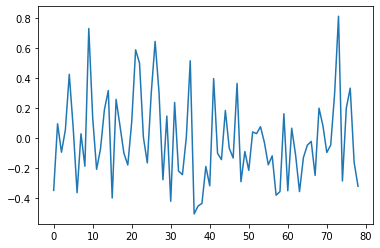

In [65]:
plt.plot(avg_by_stim['0'][34][:,128,60])

In [62]:
np.any(np.isnan([1,2,np.nan,4,5]))

True

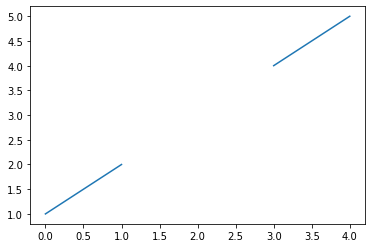

In [59]:
plt.plot([1,2,np.nan,4,5])